In [1]:
import warnings
import numpy as np
import gc
import json
import h5py
import threading
import time
import seaborn as sn
import pandas as pd

import tensorflow as tf
from keras.utils import Sequence
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.preprocessing.sequence import _remove_long_seq
from keras.models import Sequential
from keras.layers import Embedding, TimeDistributed, Input, Dense, Flatten, Dropout, CuDNNLSTM, Bidirectional
from keras import metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


gpu_options = tf.GPUOptions(
    per_process_gpu_memory_fraction=0.65, allow_growth=False)
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                        inter_op_parallelism_threads=16, allow_soft_placement=True, gpu_options=gpu_options)
session = tf.Session(config=config)
K.set_session(session)


Using TensorFlow backend.


In [2]:
def load_vocab():
    with open('data/ams_word_index.json') as json_data:
        return json.load(json_data)

def load_index_vocab():
    index_vocab = {}
    with open('data/ams_word_index.json') as json_data:
        for word, index in json.load(json_data).items():
            index_vocab[index] = word
    return index_vocab

    
def load_glove():
    glove = {}
    with open('data/glove.model.txt') as glove_data:
        for line in glove_data:
            items = line.split()
            key = items[0]
            glove[key] = np.asarray(items[1:], dtype='float32')
    return glove


def build_embedding_layer(with_input=False, maxlen=480, vocab_dim=300, mask_zero=True):
    print("-- loading word embeddings, this may take a couple of minutes...")
    index_dict = load_vocab()
    word_vectors = load_glove()
    # adding 1 to account for 0th index (for masking)
    n_symbols = len(index_dict) + 1
    print("-- known dictionary items: ", n_symbols)
    embedding_weights = np.zeros((n_symbols, vocab_dim))
    for word, index in index_dict.items():
        embedding_weights[index, :] = word_vectors[word]
    print("-- embeddings ")
    if not with_input:
        embedding_layer = Embedding(
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False, weights=[embedding_weights])
        return embedding_layer
    else:
        # define inputs here
        input_1 = Input(shape=(maxlen,), dtype='int32')
        embedding_layer = Embedding(
            weights=[embedding_weights],
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False)(input_1)
        return (embedding_layer, input_1)


In [3]:
# Input data is obtained via batch loading from HDF5
class DataGenerator(Sequence):
    def __init__(self, batch_size=128, mode="train", dim=480,
             n_classes=13, x_hf = None, y_hf = None, shuffle=False):
        'Initialization'
        self.x_hf = x_hf
        self.y_hf = y_hf
        self.mode = mode
        self.total_len = self.y_hf.shape[0]
        self.validation_len = int(np.ceil(0.1 * self.total_len))
        self.training_len = self.total_len - self.validation_len
        if self.mode == "validation":
            self.data_len = self.validation_len
            self.list_IDs = np.arange(self.training_len, self.total_len)
        else:
            self.data_len = self.training_len
            self.list_IDs = np.arange(0,self.training_len+1)
            
        self.dim = dim
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end() 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples,  dim)
        # Initialization
        X = np.empty((self.batch_size, self.dim), dtype=int)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.x_hf[ID]
            # Store class
            y[i] = self.y_hf[ID]
        
        return X, y
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

batch_size = 128
# Parameters
data_hf = h5py.File("data/confusion_free_ams.hdf5", 'r')
generator_params = {
    'batch_size': batch_size,
    'n_classes': 13,
    'shuffle': False,
    'x_hf': data_hf['x_train'],
    'y_hf': data_hf['y_train']
}
# Generators
training_generator = DataGenerator(**generator_params)
validation_generator = DataGenerator(mode="validation", **generator_params)


In [4]:
# preparing word embeddings
# Takes 10 minutes to recompute, memoizing here for the v4 49 class variant:
# class_weights = compute_class_weight('balanced', np.unique(training_generator.y_hf), training_generator.y_hf)
# np.set_printoptions(precision=32, suppress=True)
# print(class_weights)

class_weights = [
    0.7792753391061454, 4.951332154253932, 2.001955500852656,
    1.1697059411613484, 2.721513181042234, 1.16662253697677,
    513.2617350700418,  0.373816961226278, 0.19784541616346885,
    13.943577058275665, 30.542000584966363, 1.2482589205666128,
    3.348237013321448 ]

# 08.2018 (subformula lexemes)
# Analyzing the arxiv dataset seems to indicate 
#   a maxlen of 960 is needed to fit 99.2% of the data
#   a maxlen of 480 fits 96.03%, and a maxlen of 300 covers 90.0% of paragraphs
maxlen = 480
n_classes = 13
layer_size = 128

In [5]:
embedding_layer = build_embedding_layer(maxlen=maxlen, mask_zero=False)

-- loading word embeddings, this may take a couple of minutes...
-- known dictionary items:  1000296
-- embeddings 


In [6]:
model_file = "baseline_logistic_regression_cat%d" % (n_classes)

# Checkpoints: 1) save best model at epoch end, 2) stop early when metric stops improving
checkpoint = ModelCheckpoint(model_file+"-checkpoint.h5",
                             monitor='val_weighted_sparse_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystop = EarlyStopping(monitor='val_weighted_sparse_categorical_accuracy',
                          min_delta=0.001,
                          patience=3,
                          restore_best_weights=True,
                          verbose=0, mode='auto')

In [8]:
# 1. Baseline: logistic regression with GloVe
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              weighted_metrics=[metrics.sparse_categorical_accuracy])

model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    workers = 1,
    use_multiprocessing=False,
    class_weight=class_weights,
    epochs=500,
    verbose=1,
    callbacks=[checkpoint, earlystop])

print('Logistic regression model summary:')
print(model.summary())

print("-- saving model to disk : %s " % model_file)
model.save(model_file+'_notebook.h5')

Epoch 1/500
58738/58738 [==============================] - 1900s 32ms/step - loss: 2.3088 - weighted_sparse_categorical_accuracy: 0.7276 - val_loss: 2.6781 - val_weighted_sparse_categorical_accuracy: 0.7384

Epoch 00001: val_weighted_sparse_categorical_accuracy improved from -inf to 0.73841, saving model to baseline_logistic_regression_cat13-checkpoint.h5
Epoch 2/500
58738/58738 [==============================] - 1885s 32ms/step - loss: 2.4554 - weighted_sparse_categorical_accuracy: 0.7538 - val_loss: 2.7105 - val_weighted_sparse_categorical_accuracy: 0.7410

Epoch 00002: val_weighted_sparse_categorical_accuracy improved from 0.73841 to 0.74101, saving model to baseline_logistic_regression_cat13-checkpoint.h5
Epoch 3/500
58738/58738 [==============================] - 1847s 31ms/step - loss: 2.4960 - weighted_sparse_categorical_accuracy: 0.7632 - val_loss: 2.7614 - val_weighted_sparse_categorical_accuracy: 0.7399

Epoch 00003: val_weighted_sparse_categorical_accuracy did not improve fro

In [9]:
# from keras.models import load_model
# model = load_model(model_file+"_notebook.h5")

In [10]:
print("Per-class test measures:")
y_pred = model.predict_classes(data_hf['x_test'], verbose=1, batch_size=batch_size)
print(classification_report(data_hf['y_test'], y_pred))

Per-class test measures:
2088449/2088449 [==============================] - 57s 27us/step
              precision    recall  f1-score   support

           0       0.80      0.85      0.82    206155
           1       0.99      0.99      0.99     32445
           2       0.70      0.54      0.61     80246
           3       0.68      0.44      0.53    137342
           4       0.58      0.29      0.39     59029
           5       0.76      0.76      0.76    137706
           6       0.72      0.63      0.67       313
           7       0.79      0.81      0.80    429756
           8       0.82      0.93      0.87    811998
           9       0.77      0.43      0.55     11521
          10       0.62      0.35      0.45      5259
          11       0.60      0.45      0.52    128699
          12       0.65      0.59      0.62     47980

   micro avg       0.78      0.78      0.78   2088449
   macro avg       0.73      0.62      0.66   2088449
weighted avg       0.77      0.78      0.77 

In [11]:
np.set_printoptions(precision=2)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        annot = True
        print("Normalized confusion matrix")
    else:
        annot = False
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(50,40))
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=annot)

Confusion matrix, without normalization


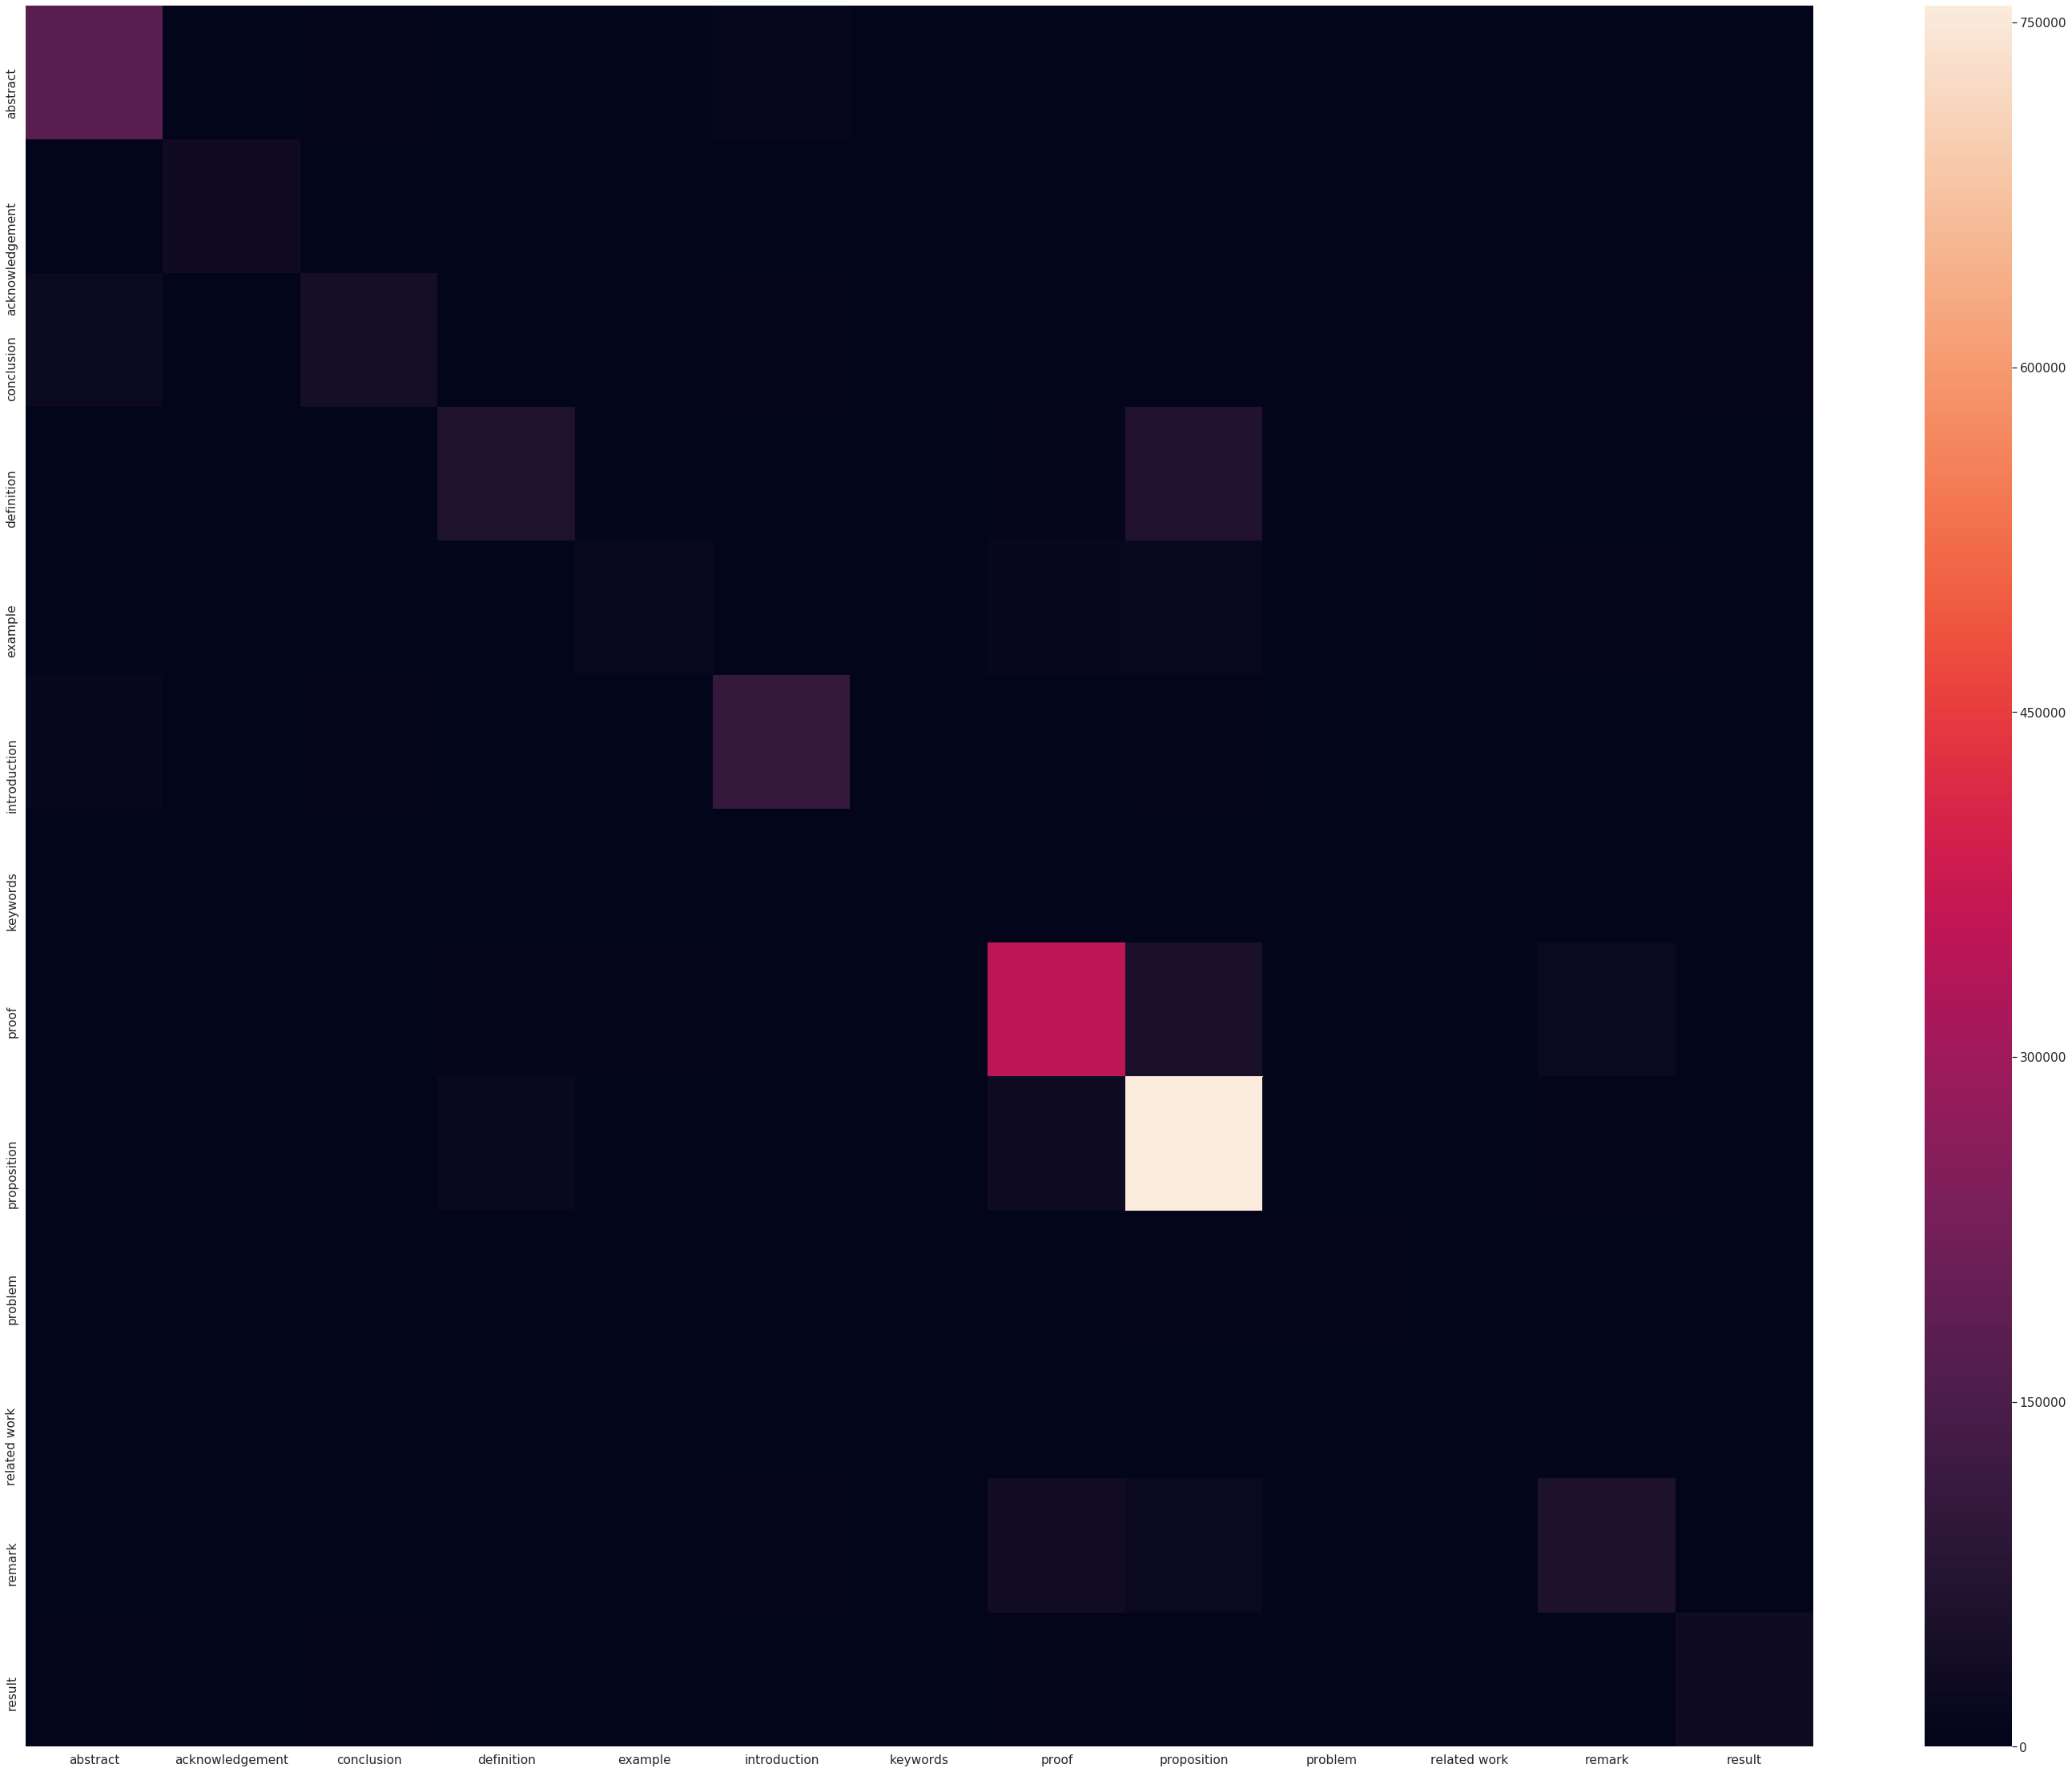

In [12]:
# Plot non-normalized confusion matrix
class_names = [
    'abstract', 'acknowledgement', 'conclusion', 'definition', 'example',
    'introduction', 'keywords', 'proof', 'proposition', 'problem', 'related work', 'remark', 'result']

plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


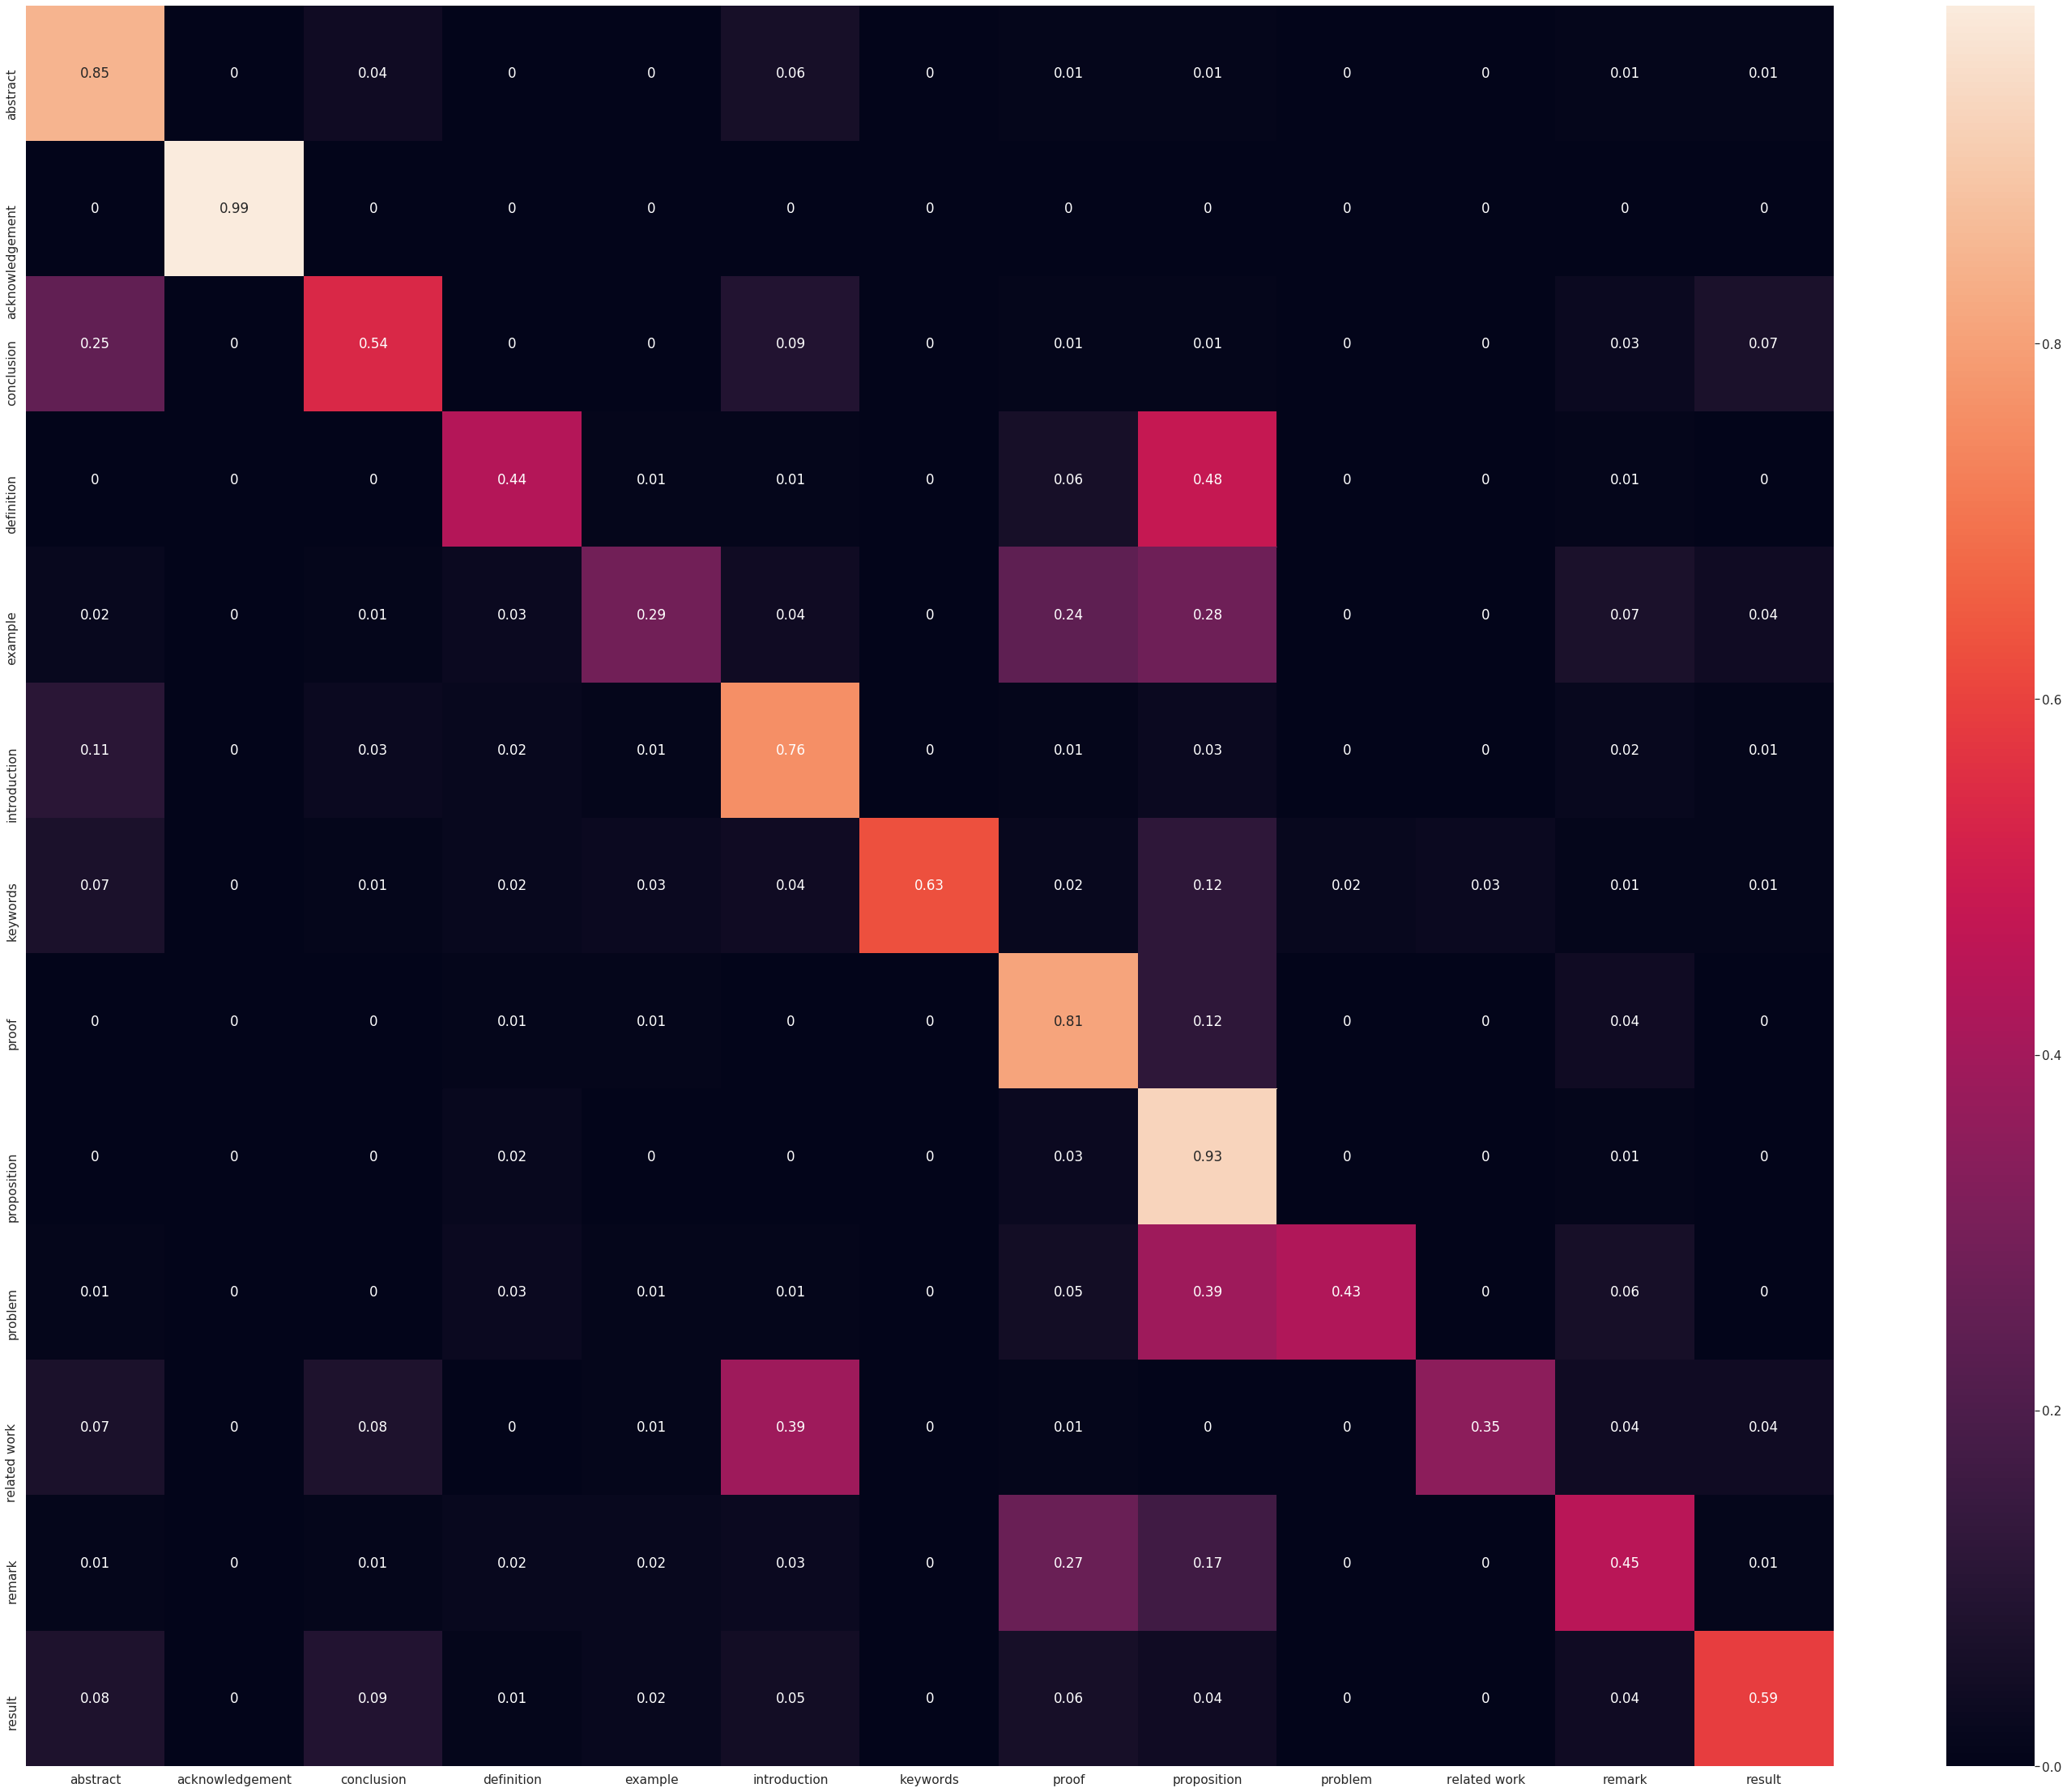

In [13]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
# 2. Baseline: logistic regression, plain
model_file = "baseline_logreg_plain_cat%d" % (n_classes)

# Checkpoints: 1) save best model at epoch end, 2) stop early when metric stops improving
checkpoint = ModelCheckpoint(model_file+"-checkpoint.h5",
                             monitor='val_weighted_sparse_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystop = EarlyStopping(monitor='val_weighted_sparse_categorical_accuracy',
                          min_delta=0.001,
                          patience=3,
                          restore_best_weights=True,
                          verbose=0, mode='auto')

model = Sequential()
model.add(Dense(n_classes, input_shape=(480,), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              weighted_metrics=[metrics.sparse_categorical_accuracy])

model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    workers = 1,
    use_multiprocessing=False,
    class_weight=class_weights,
    epochs=500,
    verbose=1,
    callbacks=[checkpoint, earlystop])

print('Plain Logistic regression model summary:')
print(model.summary())

print("-- saving model to disk : %s " % model_file)
model.save(model_file+'_notebook.h5')

Epoch 1/500
58738/58738 [==============================] - 1759s 30ms/step - loss: 9.4608 - weighted_sparse_categorical_accuracy: 0.4129 - val_loss: 9.4690 - val_weighted_sparse_categorical_accuracy: 0.4124

Epoch 00001: val_weighted_sparse_categorical_accuracy improved from -inf to 0.41243, saving model to baseline_logreg_plain_cat13-checkpoint.h5
Epoch 2/500
58738/58738 [==============================] - 1781s 30ms/step - loss: 9.3747 - weighted_sparse_categorical_accuracy: 0.4183 - val_loss: 9.4695 - val_weighted_sparse_categorical_accuracy: 0.4125

Epoch 00002: val_weighted_sparse_categorical_accuracy improved from 0.41243 to 0.41246, saving model to baseline_logreg_plain_cat13-checkpoint.h5
Epoch 3/500
58738/58738 [==============================] - 1856s 32ms/step - loss: 9.3718 - weighted_sparse_categorical_accuracy: 0.4185 - val_loss: 9.4446 - val_weighted_sparse_categorical_accuracy: 0.4140

Epoch 00003: val_weighted_sparse_categorical_accuracy improved from 0.41246 to 0.41398,

In [ ]:
print("Per-class test measures:")
y_pred = model.predict_classes(data_hf['x_test'], verbose=1, batch_size=batch_size)
print(classification_report(data_hf['y_test'], y_pred))

# Discussion

Converges in 14 epochs.

## Testing Linear Regression + GloVe 13 class
```
Per-class test measures:
2088449/2088449 [==============================] - 57s 27us/step
              precision    recall  f1-score   support

           0       0.80      0.85      0.82    206155
           1       0.99      0.99      0.99     32445
           2       0.70      0.54      0.61     80246
           3       0.68      0.44      0.53    137342
           4       0.58      0.29      0.39     59029
           5       0.76      0.76      0.76    137706
           6       0.72      0.63      0.67       313
           7       0.79      0.81      0.80    429756
           8       0.82      0.93      0.87    811998
           9       0.77      0.43      0.55     11521
          10       0.62      0.35      0.45      5259
          11       0.60      0.45      0.52    128699
          12       0.65      0.59      0.62     47980

   micro avg       0.78      0.78      0.78   2088449
   macro avg       0.73      0.62      0.66   2088449
weighted avg       0.77      0.78      0.77   2088449
```